# 平稳性
严平稳：联合正态分布$ (r_{t_{1}},...r_{t_{k}}) 和 (r_{t_{1}+t},...r_{t_{k}+t}) $对于所有的$t$都是同样的 

弱平稳： $r_{t} 的均值和 r_{t} 与 r_{t-1} 的协方差随时间不变，只与 l 有关。 \gamma _{l}=Cov(r_{t},r_{t-l})$

两者关系：若严平稳二阶矩存在，则严平稳可以得出弱平稳，相反则不成立。但是假如序列$ r_{t} $是正态分布的，严平稳和弱平稳是等价的。

为什么我们需要平稳性？

- 平稳的时间序列预测更简单，因为我们可以假设未来的统计性质和现在是一样的
- 在时间序列中大多数模型都假设协方差平稳（如上第三个图），这意味着当描述性统计（均值、方差、相关性）非常依赖于时间序列的平稳性  

例如，假如一个时间序列在过去是一直增长的，那么样本均值和方差随着样本量增加也跟着增长，那么在未来均值和方差会一直被低估。如果一个序列的均值和方差没有明确定义，那么它与其他变量的相关性也同样如此.

但是我们遇到的大多数金融时间序列是不平稳的，因此时间序列分析中有一大部分需要判断我们要进行预测的序列是否平稳，假如不是，我们需要进行转化成平稳序列。

# 序列相关（自相关性）

本质上，当我们拟合时间序列时，我们将序列分解为三部分：长期趋势、季节性/循环性、随机性。随机部分叫做残差或误差，它是预测值与观察值的差。当时间序列的随机残差存在自相关时，就序列相关。  

为什么我们需要关心序列相关  

我们关心序列相关是因为它对我们模型预测的正确性有重要的影响，序列相关本质上也和平稳性有关。回顾定义，平稳序列的残差是序列不相关的（应该有条件，见下注）。假如我们模型不能说明这点，模型系数的标准差将被低估，从而扩大T统计量的大小。结果会出现很多type-1错误——我们会拒绝原假设，即使它是对的。通俗来说，忽略自相关意味着模型预测将是空谈，关于模型里独立变量的影响，我们可能得出错误的结论。（注：我们构建的模型，最后的残差一定是序列不相关的，因为序列相关的话就是模型没完全表示，模型就错了）  

检验序列是否完全不相关，即需要检验所有自相关系数是否为0，即判断是否为白噪声。

# 白噪音和随机游走

白噪声是我们第一个需要理解的时间序列模型。根据定义，作为白噪声过程的时间序列具有连续不相关的误差，并且这些误差的预期均值等于零。对于连续续不相关的误差的另一种描述是独立同分布。这是非常重要，假如我们的时间序列模型合理且成功的抓住了潜在的过程，模型的残差将是独立同分布的，就像一个白噪声过程。因此时间序列分析试图为时间序列拟合一个模型，使残差序列与白噪声难以分辨。

【当一随机过程独立同分布且均值、方差是常数则是白噪声过程。特别是当均值为零，方差为常数时为高斯白噪声（可以看出白噪声是弱平稳的）。此为蔡瑞书上定义】

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt     
#tsa为Time Series analysis缩写
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
#模拟一个白噪声看一看
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):   #判断类型
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()
    return

In [3]:
#设置token
import tushare as ts
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
pro=ts.pro_api(token)

In [4]:
#获取沪深300指数数据
df=pro.index_daily(ts_code='000300.SH')
df.index=pd.to_datetime(df.trade_date)
df=df.sort_index()
df.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2005-01-04,000300.SH,20050104,982.794,994.769,994.769,980.658,1000.000,-17.206,-1.7206,7412868.94,4431977.418
2005-01-05,000300.SH,20050105,992.564,981.577,997.323,979.877,982.794,9.770,0.9941,7119108.98,4529208.214
2005-01-06,000300.SH,20050106,983.174,993.331,993.788,980.330,992.564,-9.390,-0.9460,6288029.05,3921015.420
2005-01-07,000300.SH,20050107,983.958,983.045,995.711,979.812,983.174,0.784,0.0797,7298694.09,4737469.399
2005-01-10,000300.SH,20050110,993.879,983.760,993.959,979.789,983.958,9.921,1.0083,5791697.99,3762932.890


In [5]:
lrets=np.log(df.close/df.close.shift(1)).dropna()

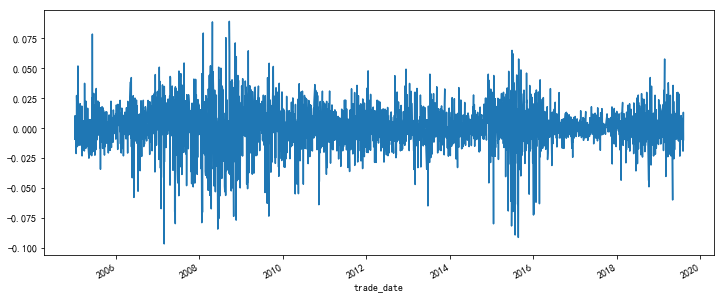

In [6]:
lrets.plot(figsize=(12,5))

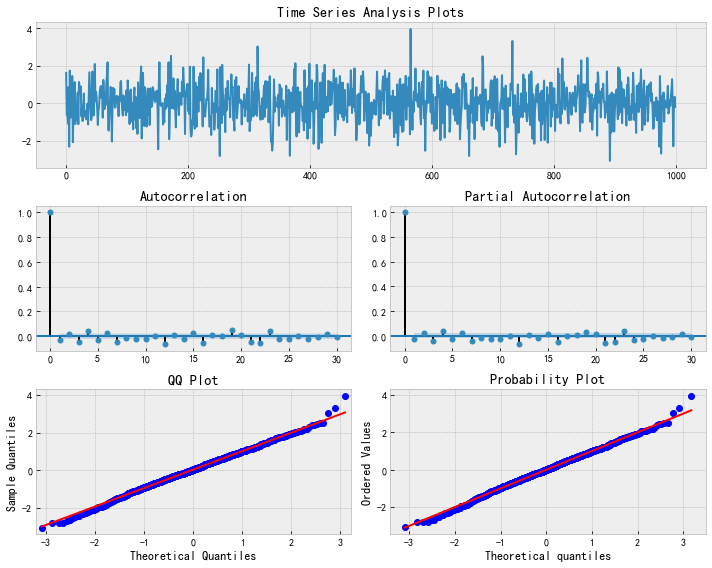

In [7]:
#简单模拟个白噪声过程
np.random.seed(1)
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

可以看到过程是随机且在0附近波动。ACF和PACF显示没有明显的序列相关。要记住，由于是正态分布采样的结果，我们应该在自相关图中看到大约5％的显著性。最下面，QQ图和概率图是比较数据的概率分布和其他理论的分布。在这里，理论分布是标准正态分布，因此我们的数据是正态分布，符合高斯白噪声。
随机游走：随机游走是时间序列$ x_{t}$ 的模型：$ x_{t}=x_{t-1}+w_{t} ， w_{t} $是离散的白噪声序列。
随机游走是不平稳的，因为协方差是和时间相关的。如果我们建模的时间序列是随机游走的，那么它是不可预测的。

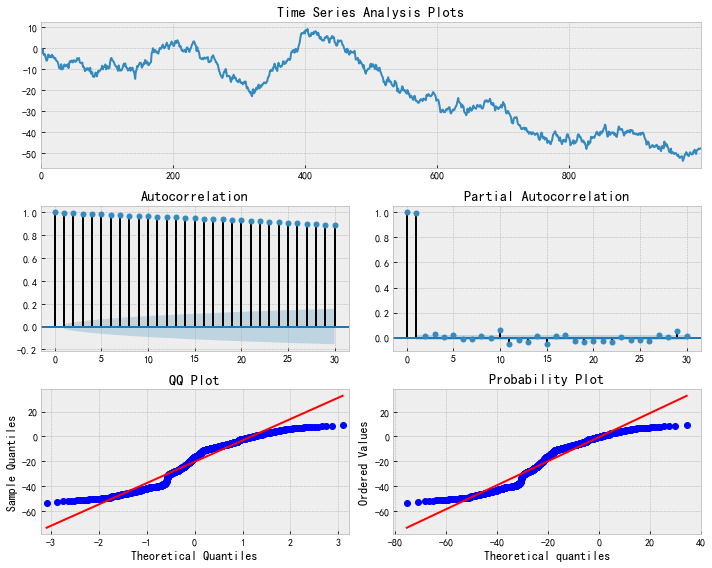

In [37]:
#从标准正态分布采样模拟一个随机游走
np.random.seed(2)
n_samples = 1000
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):   #应该从1开始，但影响不大，x[-1]也有值
    x[t] = x[t-1] + w[t]
tsplot(x, lags=30)

明显看出序列是不平稳的。让我们看看随机游走对我们的模拟数据是否很好的拟合。回忆随机游走模型是$ x_{t}=x_{t-1}+w_{t} 。移项可以得到 x_{t}-x_{t-1}=w_{t} $。因此，随机游走的一阶差分应该等于白噪声。我们可以对时间序列使用 np.diff() 函数看它是否成立。

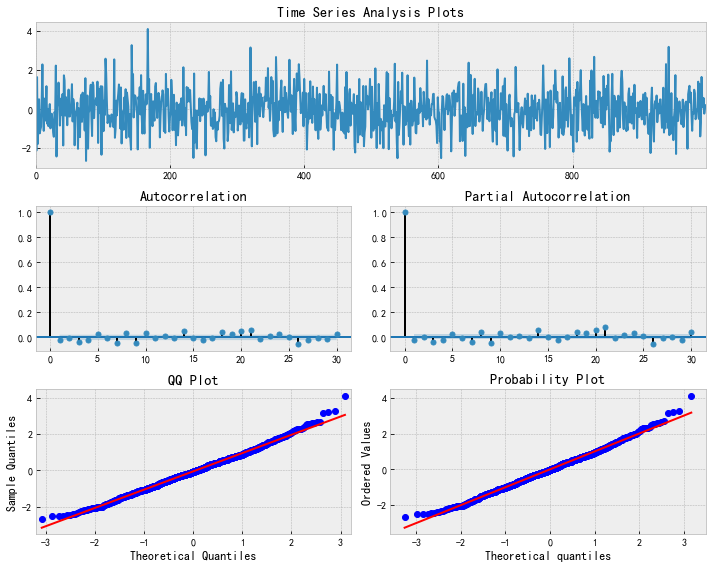

In [38]:
# First difference of simulated Random Walk series
tsplot(np.diff(x), lags=30)

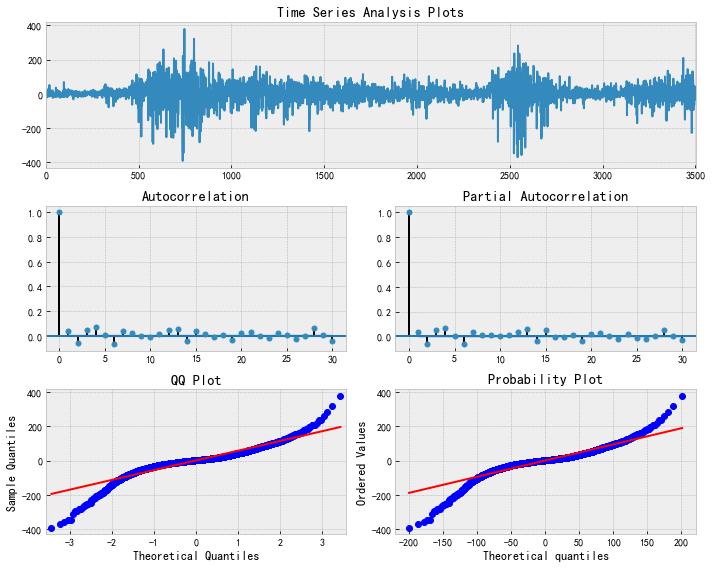

In [44]:
#确实是白噪声过程！假如我们用随机游走拟合沪深300价格的一阶差分会如何？
tsplot(np.diff(df.close),lags=30)

非常像白噪声！但是看QQ图和概率图。这个过程很像标准正态分布但是有厚尾。在ACF和PACF图上有一些重要的序列相关性，在2，4？6？,..,lags。这意味着应该有更好的模型去描述真实的价格变化过程。

# 趋势平稳时间序列

## 直线模型
可以用直线来刻画时间序列。基本方程是： $ y_{t}=b_{0}+b_{1}t+\varepsilon _{t}$

在这个模型中，因变量的值由 $\beta 系数和自变量时间来决定。让我们看一个构造的例子，我们假设ABC公司的销售在初始是\$50.00（即 \beta_{0}$或截距项），每隔时间步长增加\$25.00(即 \beta_{1} )$

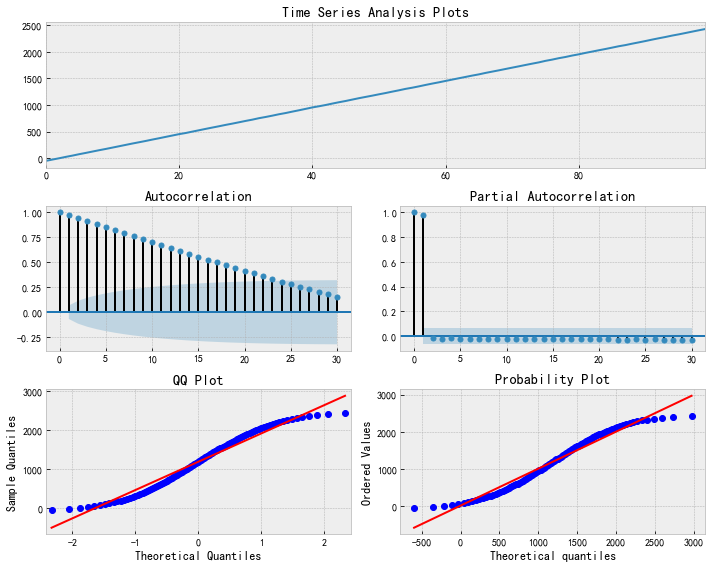

In [45]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step
w = np.random.randn(100)
y = np.empty_like(w)
b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
tsplot(y, lags=30)

模型的残差是序列相关的，且随着方程滞后的增加线性关系逐渐减少。分布接近正态。在使用线性模型做预测时我们应该考虑并去除序列里面明显的自相关成分。PACF在滞后1的意义表明AR模型可能是适合的。

## 对数线性模型  
对数线性模型和线性模型很像，不同之处在于数据点形成指数函数，其表示关于每个时间步长的恒定变化率。例如，ABC公司销售量每隔一段时间增长X%，下面是一个模拟的销售数据图。

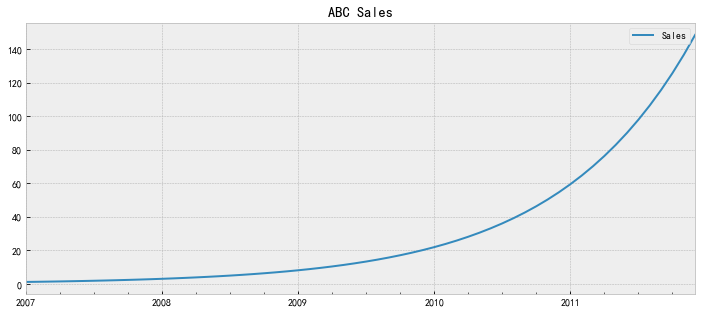

In [47]:
# Simulate ABC exponential growth
# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')
# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]
# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)
with plt.style.context('bmh'):
    df.plot(figsize=(12,5))
    plt.title('ABC Sales')

可以用自然对数对销售量进行转换。之后线性模型就能很好的拟合数据了。

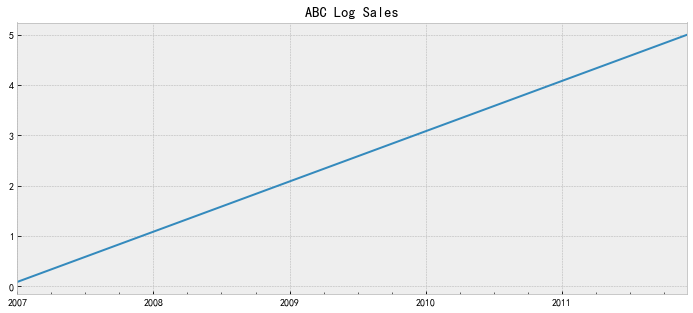

In [48]:
# ABC log sales 
with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot(figsize=(12,5))
    plt.title('ABC Log Sales')

这些模型有个致命的缺点。它假设序列不相关的误差，正如我们看到的，在线性模型中是不对的。在真实世界中，时间序列通常违背平稳性假设，这使促使我们进入自回归模型。

# 时间序列模型
时间序列模型主要分为四种：自回归模型AR，移动回归模型MA，两种的结合移动自回归模型ARMA，以及差分移动自回归模型ARIMA

## AR模型
因变量能由它的多个滞后项表示称为自回归模型（AR）。  
p阶自回归模型可以写成：
$$x_t=\phi_0+\phi_1x_{t-1}+\phi_2x_{t-2}+...+\phi_px_{t-p}+\mu_t$$
$x_{t-p}是x_t的滞后p阶，\phi_p为自回归系数，\mu_t为白噪音，满足标准正态分布$。  

模拟一个AR(1)模型，让 $\phi_{0}为零， \phi_{1}$ 等于0.6

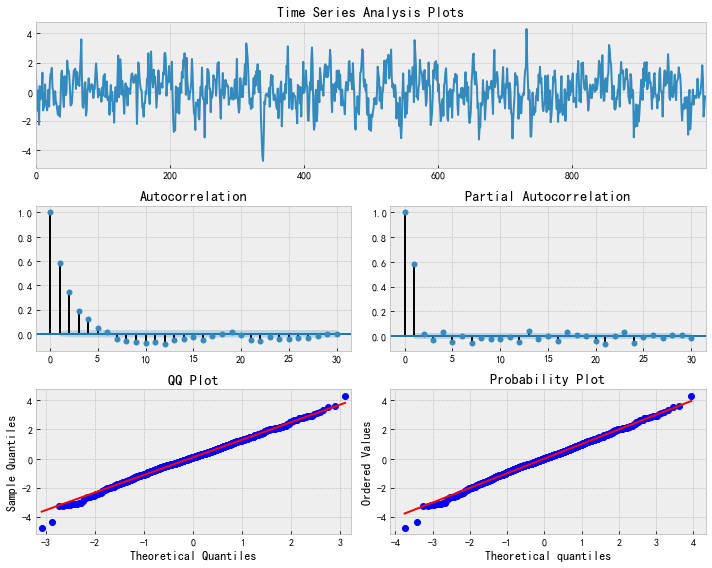

In [49]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
tsplot(x, lags=30)

模拟的AR(1)模型是正态的。滞后值之间存在显着的序列相关性，尤其是在滞后1时，PACF图证明了这一点。现在我们使用python的statsmodels去够构建AR(p)模型。首先我们用AR模型区拟合我们模拟的数据，返回估计的alpha系数。然后我们用statsmodels函数取选择阶数，看是否选择了正确的滞后项。假如AR模型是正确的，那估计的alpha系数将很接近真实的alpha系数0.6，选择的阶数也会等于1。

In [51]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')  
#ic : 有四个选择 {‘aic’,’bic’,’hqic’,’t-stat’}
#trend：是否包含常数项， ‘c’ - include constant. ‘nc’ - no constant.

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


大概找到了我们模拟数据的参数。让我们模拟AR(2)过程，用alpha1 = 0.666和alpha2 = -0.333。这次我们将使用statsmodel的 "arma_generate_samples()"函数。这个函数允许我们模拟任意阶数的AR模型。

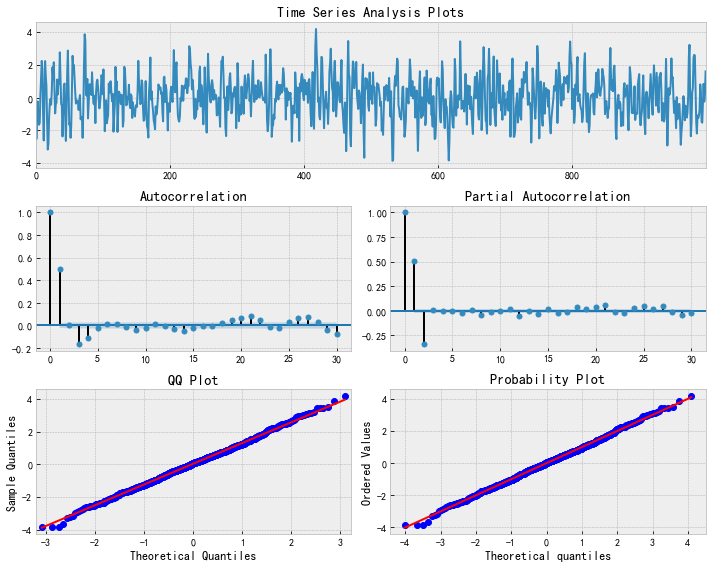

In [52]:
# Simulate an AR(2) process
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
ar = np.r_[1, -alphas]  #np.r_是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()
ma = np.r_[1, betas]    #np.c_是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ar2, lags=30)

In [53]:
#看一下是否能复现参数
# Fit an AR(p) model to simulated AR(2) process
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


看下如何用AR(p)模型来拟合沪深300的对数收益

In [159]:
# Select best lag order for hs300 returns
df=pro.index_daily(ts_code='000300.SH')
df.index=pd.to_datetime(df.trade_date)
del df.index.name
df=df.sort_index()
df['ret']=np.log(df.close/df.close.shift(1))
max_lag = 30
Y=df.ret.dropna().values
mdl = smt.AR(Y).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(Y).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))

best estimated lag order = 15


最好的阶数选择是23或者有23个参数！任何模型有这么参数在实际中不可能有用。显然有比这个模型更复杂的模型可以解释

### AR(p)建模

AR(p)建模的几个步骤: 特征根及平稳性检验——模型定阶——模型检验——拟合优度及预测

### 特征根及平稳性检验

我们先假定序列是弱平稳的，则有：
$$E(x_{t})=u,Var(x_{t})=\gamma _{0},Cov(x_{t},x_{t-j})=\gamma_{j} $$，$其中 u,\gamma_{j} 是常数
因为 w_{t} $是白噪声，因此$$ E(w_{t})=0,Var(w_{t})=\sigma _{\alpha }^{2}$$
将上面带入：$$ x_{t}=\alpha _{0}+\alpha _{1}x_{t-1}+...+\alpha _{p}x_{t-p}+\omega _{t}$$
得到：$$ E(x_{t})=u=\frac{\alpha _{0}}{1-\alpha _{1}-\alpha _{2}-...-\alpha _{p}}$$
假设分母不为零，我们得到特征方程：
$$1-\alpha _{1}x-\alpha _{2}x^{2}-...-\alpha _{p}x^{p}=0$$

该方程所有解的倒数称为该模型的特征根，如果所有的特征根的模都小于1，则该AR(p)序列是平稳的。

### AR(p)模型的定阶

有两种方法：

第一种：利用偏相关函数(PACF)——AR(p)序列的样本偏相关函数是 p 阶截尾的。（所谓截尾，就是快速收敛即快速的降到几乎为0或者在置信区间以内。）

第二种：利用信息准则函数  

1.AIC(akaike information criterion) AIC = -2 ln(L) + 2 k   
增加自由参数提高了拟合的优良性，AIC鼓励数据拟合的优良性但是尽量避免出现过度拟合(Overfitting)的情况。所以优先考虑的模型应是AIC值最小的那一个。AIC的方法是寻找可以最好地解释数据但包含最少自由参数的模型。  

2.BIC (bayesian information criterion) BIC = -2 ln(L) + ln(n)*k   

3.HQC (hannan-quinn criterion) HQ = -2 ln(L) + ln(ln(n))*k

### 模型的检验

在白噪声部分我们提到“假如我们的时间序列模型合理且成功的抓住了潜在的过程，模型的残差将是独立同分布的，就像一个白噪声过程。因此时间序列分析试图为时间序列拟合一个模型，使残差序列与白噪声难以分辨。”因为检验残差是否是白噪声来模型是否有效。我们可以用混成检验，来检验残差与白噪声的接近程度。

### 拟合优度及预测

我们用下面的统计量来判断拟合优度：$ R^{2}=1-\frac{残差平方和}{总的平方和}$  

但是，对于一个给定的数据集，$R^2是用参数个数的非降函数，为了克服该缺点，可以使用调整后的R^2： AdjR^{2}=1-\frac{残差方差}{r_{t}的方差}$
它的值在0-1之间，越接近1，拟合效果越好。
接下来进行预测，我们首先得把原来的样本分为训练集和测试集，再来看预测效果

## MA模型
MA(q)模型与AR(p)模型非常相似。不同之处在于，MA(q)模型是对过去的白噪声误差项的线性组合，而不是过去观测的线性组合。MA模型的动机是我们可以直接通过拟合误差项的模型来观察误差过程中的“冲击”。在一个AR(p)模型中，通过在一系列过去的观察中使用ACF间接观察到这些冲击。MA(q)模型的公式是：

$$x_{t}=c_{0}+\omega _{t}+\beta _{1}\omega _{t-1}+...+\beta _{p}\omega _{t-p}$$

$\omega 是白噪声， E(\omega_{t})=0 ，方差是 \sigma_{a}^{2} $。  
让我们使用beta=0.6模拟这个过程。

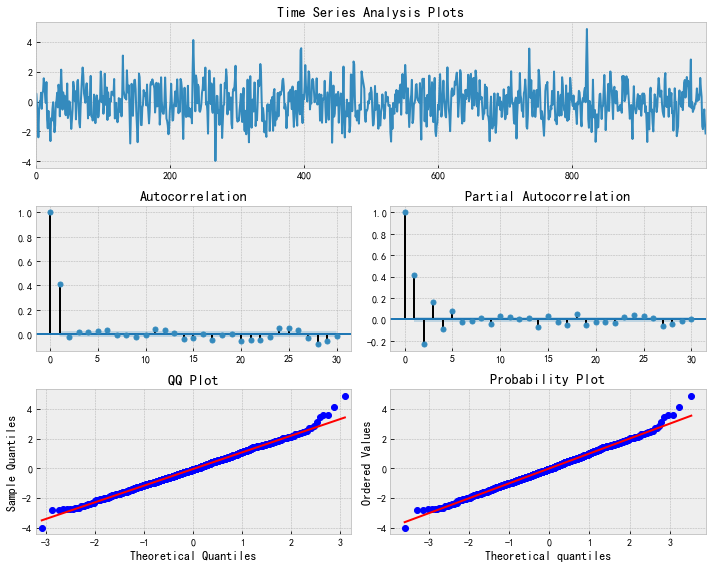

In [75]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ma1, lags=30)

ACF函数表明滞后1是显着的，这表明MA（1）模型可能适合我们的模拟系列。但PACF在滞后2，3和4时的显著性不知道什么鬼，当ACF仅在滞后1时显示重要性。

In [76]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Thu, 06 Jun 2019   AIC                           2785.025
Time:                        14:40:06   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                  Real          Imaginary           M

该模型能够正确估计滞后系数，0.58接近我们的0.6的真实值。另请注意，我们的95％置信区间确实包含真实值。让我们尝试模拟一个MA（3）过程，然后用我们的ARMA函数将三阶MA模型拟合到这个序列中，看看我们是否可以恢复正确的滞后系数（beta）。 Betas 1-3分别等于0.6,0.4和0.2。

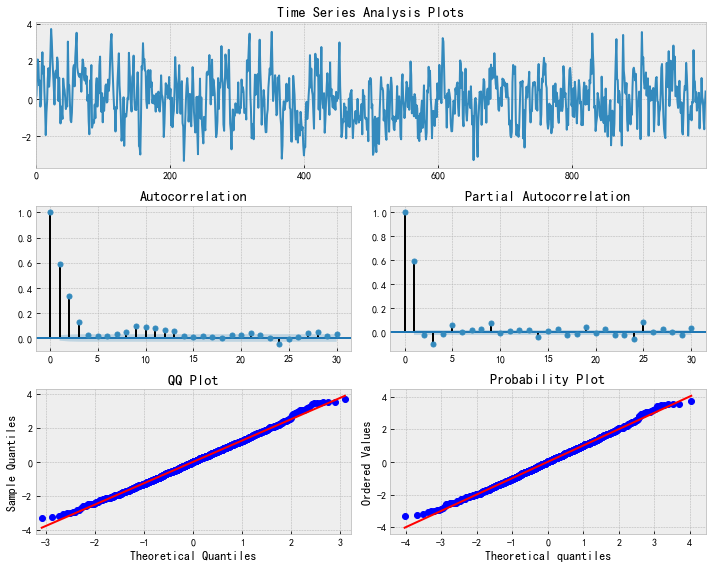

In [77]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma3, lags=30)

In [78]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Thu, 06 Jun 2019   AIC                           2862.075
Time:                        14:42:40   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

可以看到模型能到有效的估计真实系数。95％置信区间确实包含真实值。现在让我们用MA(3)模型去拟合沪深300股价的对数收益。记住我们不知道真实的参数值。

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3503
Model:                     ARMA(0, 3)   Log Likelihood                9201.851
Method:                           mle   S.D. of innovations              0.017
Date:                Thu, 06 Jun 2019   AIC                         -18395.702
Time:                        14:45:58   BIC                         -18371.056
Sample:                             0   HQIC                        -18386.907
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.0244      0.017      1.436      0.151      -0.009       0.058
ma.L2.y       -0.0280      0.016     -1.737      0.082      -0.060       0.004
ma.L3.y        0.0350      0.018      1.921      0.0

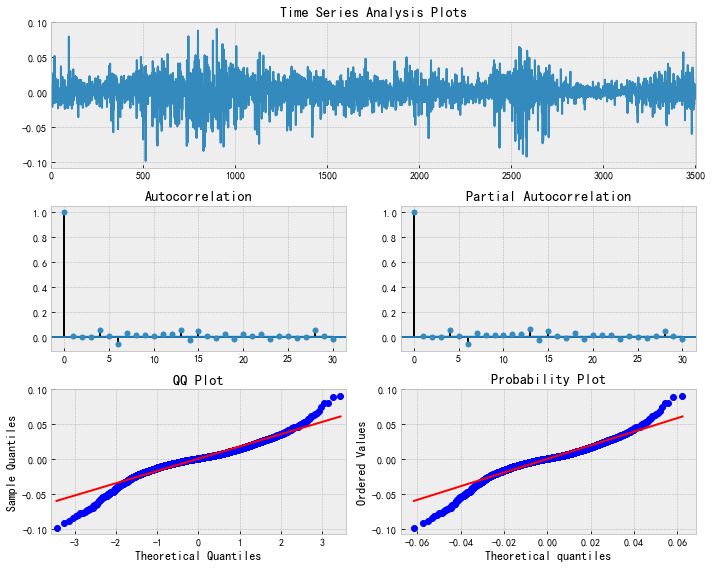

In [80]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = logret.values
mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
tsplot(mdl.resid, lags=max_lag)

还不错。ACF的某些滞后性尤其在4,6，13和15时尤为突出。它可能是抽样误差，但由于厚尾使我认为这不是预测未来SPY回报的最佳模型。

MA(q)模型：$$ x_{t}=c_{0}+\omega _{t}+\beta _{1}\omega _{t-1}+...+\beta _{p}\omega _{t-p} $$  
用了过去q个时期的随机干扰或预测误差来线性表达当前的预测值。  
平稳性：MA模型总是弱平稳的，因为他们是白噪声序列（残差序列）的有限线性组合。因此，根据弱平稳的性质可以得出两个结论：  
$E(x_{t})=c_{0} Var(x_{t})=(1+\beta_{1}^{2}+\beta_{2}^{2}+..+\beta_{p}^{2})\sigma_{a}^{2} $自相关函数：对q阶的MA模型，其自相关函数ACF总是q步截尾的。因此MA(q)序列只与其前q个延迟值线性相关，从而它是一个“有限记忆”的模型。这一点可以用来确定模型的阶次。  
可逆性：当满足可逆条件的时候，MA(q)模型可以改写为AR(p)模型。这里不进行推导，给出1阶和2阶MA的可逆性条件。  
一阶： $|\theta_{1}<1| $  
二阶： $|\theta_{2}<1| , \theta_{1}+\theta_{2}<1$

## ARMA模型
Autoregressive Moving Average Models - ARMA(p, q)  

ARMA模型仅仅是AR（p）和MA（q）模型之间的合并。让我们从量化金融的角度回顾这些模型对我们来说代表什么：

1. AR（p）模型试图捕捉（解释）交易市场中经常观察到的动量和均值回复效应。  
2. MA（q）模型尝试捕捉（解释）在白噪声条件下观察到的冲击效应。这些冲击效应可以被认为是影响观察过程的意外事件，例如，恐怖袭击  

ARMA模型的弱点在于忽视了大多数金融时间序列中的波动聚集效应。

模型的公式是:

$$x_{t}=\alpha_{0}+\alpha_{1}x_{t-1}+\alpha_{2}x_{t-2}+...+\omega_{t}+\beta _{1}\omega _{t-1}+\beta _{2}\omega _{t-2}+...+\beta _{q}\omega _{t-q}=\alpha _{0}+\sum_{i=1}^{p}\alpha _{i}x_{t-i}+\omega _{t}+\sum_{i=1}^{q}\beta _{i}\omega _{t-i}$$

让我们给定参数去模拟一个ARMA(2, 2)过程，然后用ARMA(2, 2)模型去拟合看是否能正确估计出这些变量。让$\alpha$等于[0.5,-0.25]，$\beta$等于 [0.5,-0.3]。

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Thu, 06 Jun 2019   AIC                          14162.352
Time:                        14:55:23   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

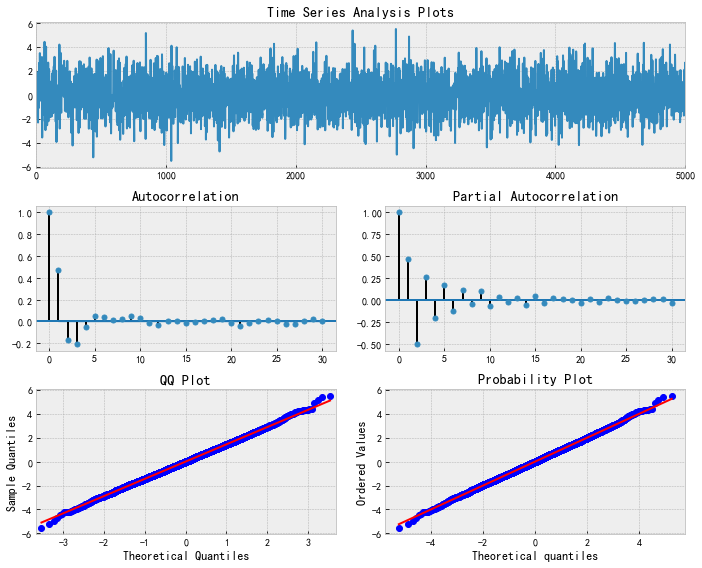

In [81]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

#burnin: to reduce the effect of initial conditions, burnin observations at the beginning of the sample are dropped
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

模型正确地恢复了我们的参数，并且我们的真实参数包含在95％置信区间内。

接下来我们模拟一个ARMA（3,2）模型。之后，我们通过p，q的参数组合来循环将ARMA模型拟合到我们的模拟序列。我们根据哪个模型产生最低的AIC来选择最佳组合。

aic: 14212.01026 | order: (3, 2)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7100.005
Method:                           mle   S.D. of innovations              1.001
Date:                Thu, 06 Jun 2019   AIC                          14212.010
Time:                        14:58:40   BIC                          14251.113
Sample:                             0   HQIC                         14225.715
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5254      0.027     19.388      0.000       0.472       0.579
ar.L2.y       -0.2634      0.016    -16.458      0.000      -0.295      -0.232
ar.L3.y        0.43

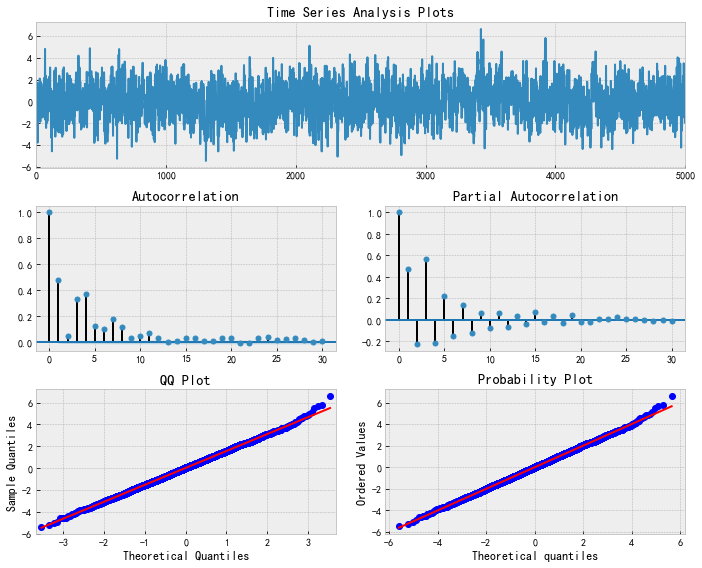

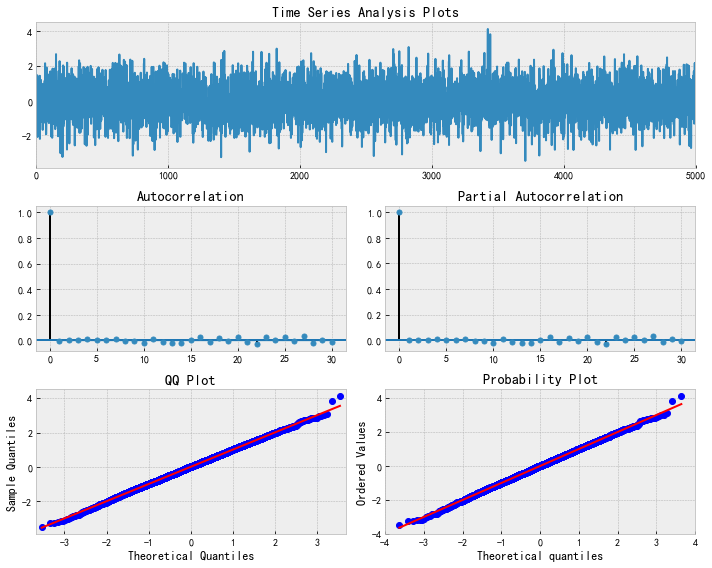

In [82]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30
n = int(5000)
burn = 2000
alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())
tsplot(best_mdl.resid, lags=max_lag)

接下来我们用ARMA去拟合沪深300的收益：

aic: -18419.37745 | order: (4, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3503
Model:                     ARMA(4, 4)   Log Likelihood                9218.689
Method:                           mle   S.D. of innovations              0.017
Date:                Thu, 06 Jun 2019   AIC                         -18419.377
Time:                        15:05:18   BIC                         -18363.925
Sample:                             0   HQIC                        -18399.588
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.2326      0.094      2.487      0.013       0.049       0.416
ar.L2.y       -0.0516      0.121     -0.425      0.671      -0.290       0.186
ar.L3.y       -0.0

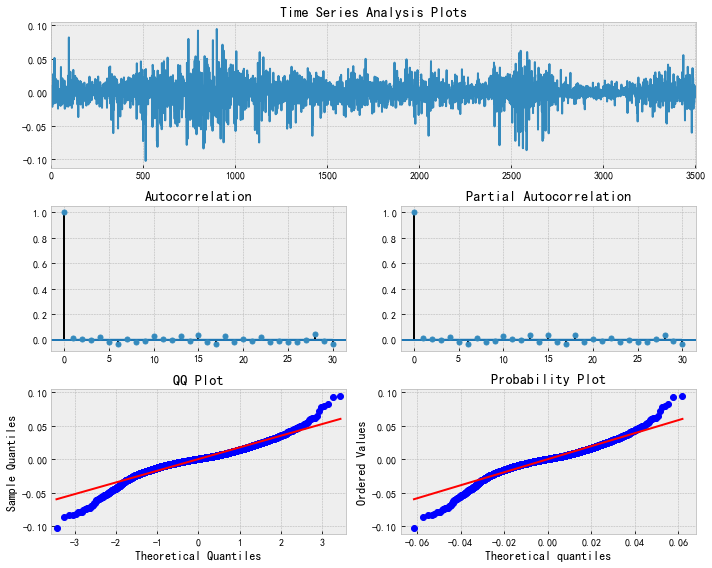

In [83]:
# Fit ARMA model to HS300 returns
best_aic = np.inf 
best_order = None
best_mdl = None
rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(Y, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())
tsplot(best_mdl.resid, lags=30)

ACF和PACF没有显示出明显的自相关性。QQ和概率图显示残差大致为正态且厚尾。但是，这个模型的残差看起来不像白噪声！看模型没有捕捉到的明显的条件异方差（条件波动性）的突出区域。

## ARIMA模型
Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)  

ARIMA是ARMA模型的延伸。如前所述，我们的许多时间序列不是平稳的，但是它们可以通过差分来实现平稳。我们看到了一个例，当我们对高斯随机游走进行一阶差分后证明它等于白噪声。换言之，我们通过一阶差分将非平稳机游走其转化为平稳的白噪声。

差分移动自回归模型，由于前三个模型都有时间序列平稳的假设在，如果时间序列存在明显的上升或者下降趋势，模型预测的效果大大折扣，对于这些有明显下降或者上升趋势的数据集，可以使用差分的方式使它们平稳，之后使用ARMA拟合。假设模型经过d次差分通过了时间序列平稳的检验，ARMA的系数为p，q，ARIMA模型为ARIMA(p，d，q）。  

在Python中，如果我们需要不止一次的差分一个时间系列，我们必须使用np.diff（）函数。Pandas里的DataFrame.diff（）/ Series.diff（）仅能差分一次，不能实现时间序列的递归差分。

在下面的例子中，我们迭代（p，d，q）不同组合，找到拟合沪深300收益的最佳ARIMA模型。我们使用AIC来评估每个模型。选取最小的AIC。

aic: -18419.37745 | order: (4, 0, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3503
Model:                     ARMA(4, 4)   Log Likelihood                9218.689
Method:                           mle   S.D. of innovations              0.017
Date:                Thu, 06 Jun 2019   AIC                         -18419.377
Time:                        16:05:28   BIC                         -18363.925
Sample:                             0   HQIC                        -18399.588
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.2326      0.094      2.487      0.013       0.049       0.416
ar.L2.y       -0.0516      0.121     -0.425      0.671      -0.290       0.186
ar.L3.y       -

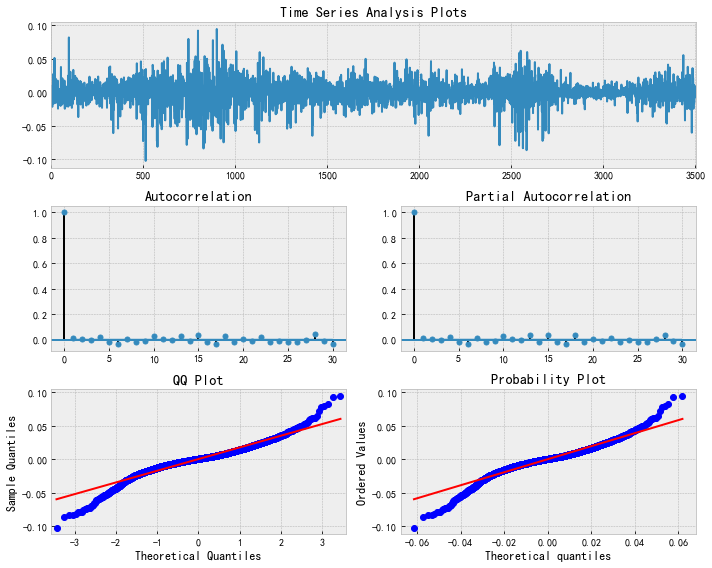

In [121]:
# Fit ARIMA(p, d, q) model to HS300 Returns
# pick best order and final model based on aic
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(logret.values, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
print(best_mdl.summary())
_ = tsplot(best_mdl.resid, lags=30)

最好的模型差分为0不足为奇。回想一下，我们已经采用了第一次对数差分来计算股票收益率。绘制模型残差，结果与我们上面所适用的ARMA（4，3）模型基本相同。显然，这个ARIMA模型并没有解释时间序列中的条件波动性！

现在我们至少有足够的知识来对未来回报进行简单的预测。这里我们利用我们模型的forecast()方法。forecast()参数里，预测的时间步数需要一个整数，而alpha参数的小数点指定置信区间。默认设置是95％的置信度。99％的阿尔法等于0.01【(1 - alpha) %】。

In [205]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

cal=pro.trade_cal(exchange='', start_date=df.index[-1])
idx = cal[cal.is_open==1][:21]['cal_date'].values
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
20190606,0.001931,-0.032195,-0.042918,0.036057,0.046781
20190610,0.000703,-0.033426,-0.044150,0.034832,0.045557
20190611,-0.001545,-0.035696,-0.046427,0.032606,0.043338
20190612,-0.001434,-0.035611,-0.046349,0.032742,0.043481
20190613,0.001269,-0.032916,-0.043658,0.035455,0.046196


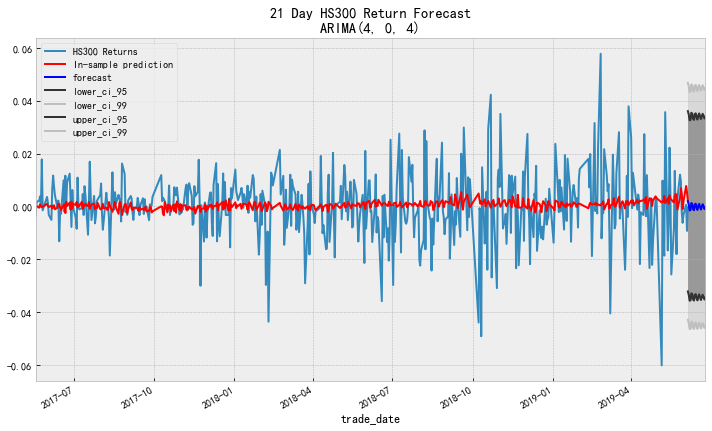

In [197]:
# Plot 21 day forecast for HS300 returns

plt.style.use('bmh')
fig = plt.figure(figsize=(12,7))
ax = plt.gca()

ts = logret[-500:].copy()
ts.plot(ax=ax, label='HS300 Returns')
# in sample prediction
pred = best_mdl.predict(np.arange(len(ts))[0], np.arange(len(ts))[-1])
pf=pd.Series(pred,index=ts.index)
pf.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day HS300 Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)
plt.show()

## ARCH模型
Autoregressive Conditionally Heteroskedastic Models - ARCH(p)  
$$Var(y_t|y_{t-1})=\sigma_t^2=\alpha_0+\alpha_1y_{t-1}^2$$

假设该时间序列均值为0，则模型可以表达为：  
$$y_t=\sigma_t\varepsilon_t, \sigma_t=\sqrt{\alpha_0+\alpha_1y_{t-1}^2},\varepsilon_t \sim iid(0,1)$$

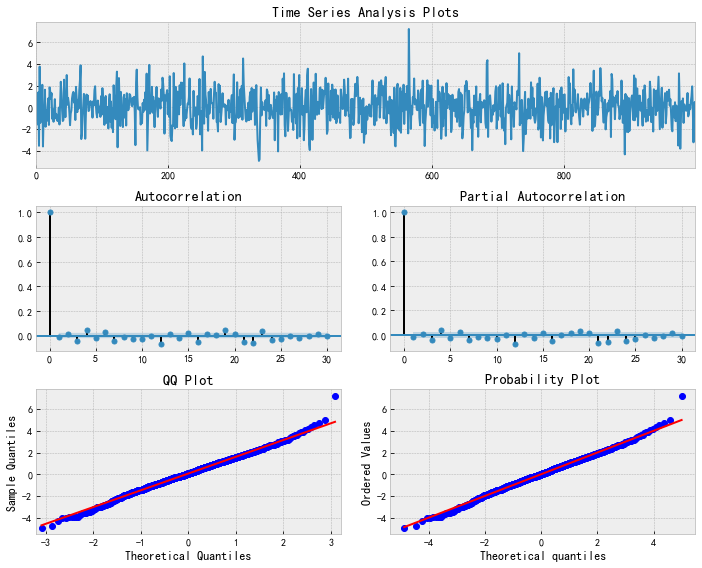

In [208]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(1)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH模型
Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)  

$$\varepsilon_t =\sigma_t\omega_t\\ \sigma_t^2 =\alpha_0+\alpha_1\varepsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

$\omega_t$为白噪音，$\alpha_1+\beta_1$必须小于1，否则模型将是非平稳的。

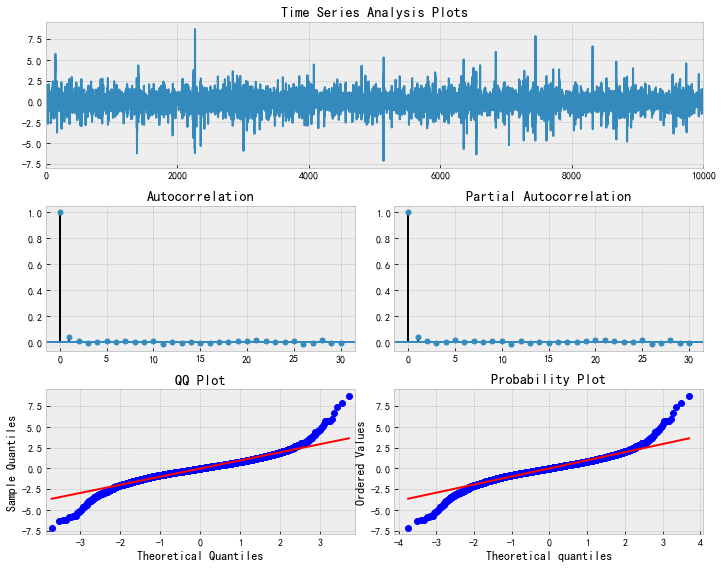

In [209]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

eps结果接近白噪音，再看看eps的平方

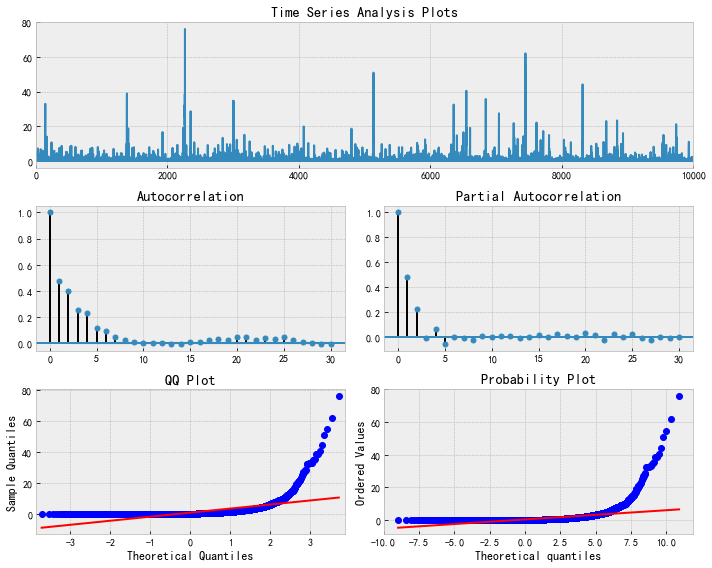

In [210]:
tsplot(eps**2, lags=30)

In [212]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Thu, Jun 06 2019   Df Residuals:                     9996
Time:      

In [218]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [221]:
# Notice I've selected a specific time period to run this analysis
TS = logret.values
res_tup = _get_best_model(TS)

aic: -18419.37745 | order: (4, 0, 4)


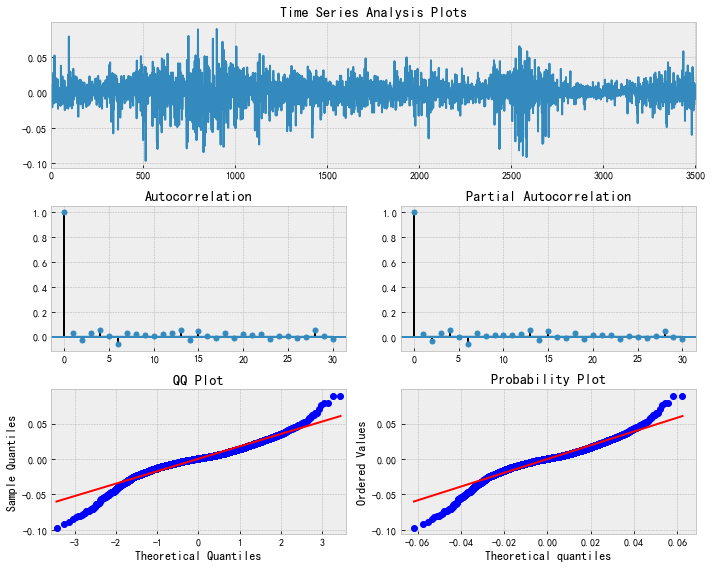

In [223]:
tsplot(TS, lags=30)

Squared residuals show autocorrelation. Let's fit a GARCH model and see how it does. 

In [233]:
# Now we can fit the arch model using the best fit arima model parameters
order=res_tup[1]
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                6641.80
Distribution:      Standardized Student's t   AIC:                          -13261.6
Method:                  Maximum Likelihood   BIC:                          -13193.8
                                              No. Observations:                 3503
Date:                      Thu, Jun 06 2019   Df Residuals:                     3492
Time:                              18:11:07   Df Model:                           11
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

C:\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


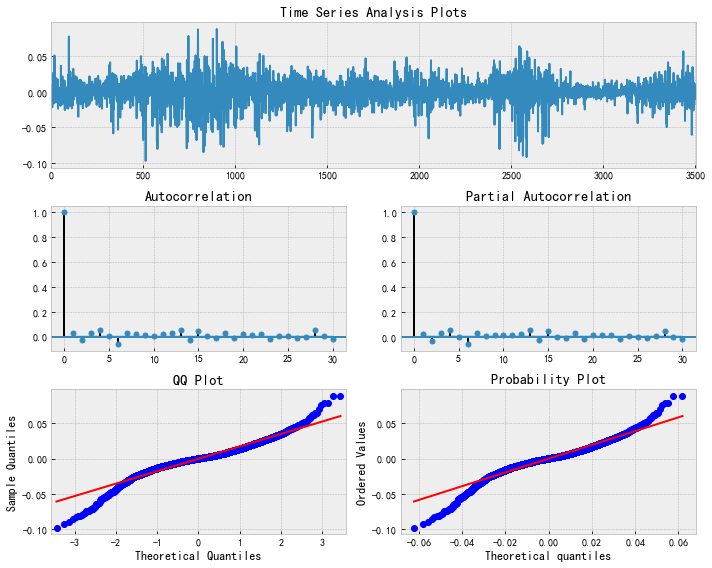

In [231]:
tsplot(res.resid, lags=30)